# Regression after Unsmoothing on Google Trend Data

This notebook would use Li2CO3 data from investing.com (which totally have data from 2018 to 2023) and the unit is CNY/TON. 

Google Trend Data is generated from https://trends.google.com/trends/explore?date=2018-09-07%202023-11-03&gprop=news&q=lithium,EV,%2Fm%2F01pmdg,%2Fm%2F01c0z,Energy&hl=en. 

I only focus on `new search` instead of `web search`. The each cell in the google trend is the number of search. 

Lithium Price is sampled every Sunday which is consistent with the Google data. 

In [3]:
import warnings 
warnings.filterwarnings('ignore')
from utils.utils import transform_data, plot_correlogram, get_stock_data
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.tsa.arima.model as tsa

In [4]:
help(transform_data)

Help on function transform_data in module utils.utils:

transform_data(file_path, sampling_period='W-FRI')
    This function transform the price into log return and output the weekly log return and price in a dataframe.



In [5]:
li2co3 = transform_data("../data/Lithium Carbonate 99%Min China Spot Historical Data.csv", sampling_period='W-FRI')

         Date       Price        Open        High         Low  Vol. Change %
0  10/27/2023  155,500.00  155,500.00  158,000.00  153,000.00   NaN   -1.27%
1  10/26/2023  157,500.00  157,500.00  160,000.00  155,000.00   NaN   -1.25%
2  10/25/2023  159,500.00  159,500.00  162,000.00  157,000.00   NaN    1.27%
3  10/24/2023  157,500.00  157,500.00  160,000.00  155,000.00   NaN   -0.63%
4  10/23/2023  158,500.00  158,500.00  161,000.00  156,000.00   NaN   -2.46%


Please enter the column names, separated by a comma:  Date, Price, 1, 2, 3, 4, 5


<AxesSubplot: xlabel='Date'>

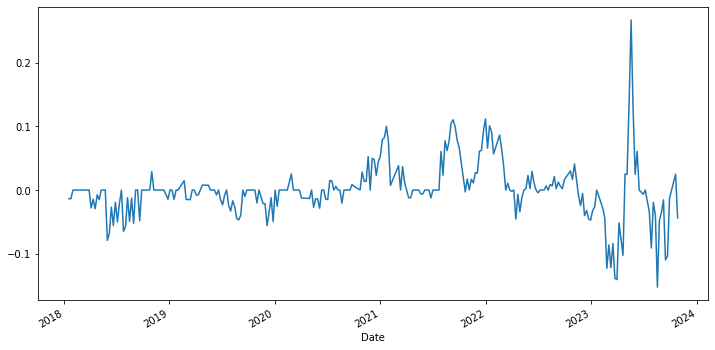

In [6]:
# Specify the size of the figure
plt.figure(figsize=(12, 6))
li2co3.Log_Return.plot()

In [7]:
# ro is observed data
ro = li2co3[li2co3.index >= '2018-01-01'].Log_Return

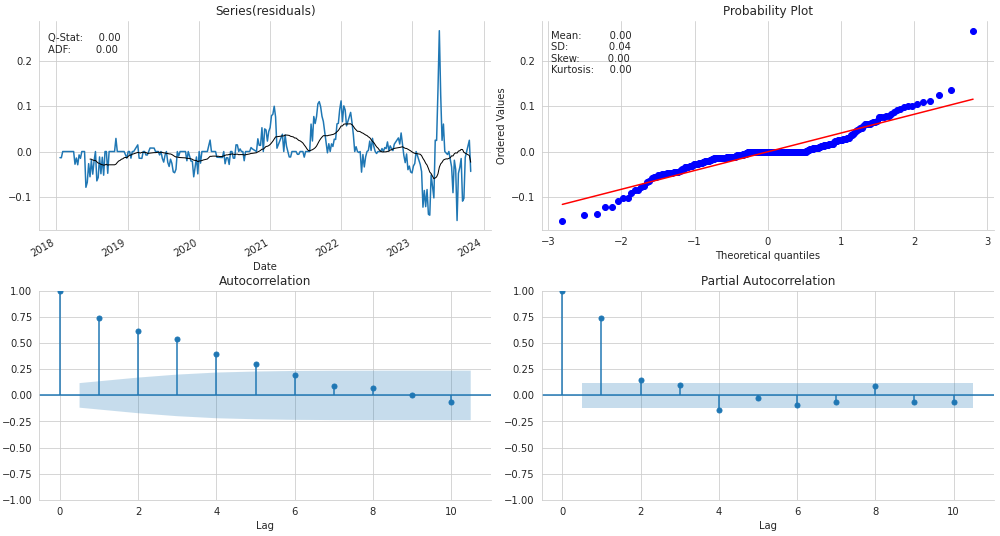

In [8]:
plot_correlogram(ro)

## AR(p = 1) 

In [9]:
# ro_stationary 

AR_1_result = tsa.ARIMA(ro,order=(1,0,0)).fit()
a, b, std = AR_1_result.params
theta = b 
mu = a/(1-b)
et = AR_1_result.resid/(1-b)
fitted = mu + et

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


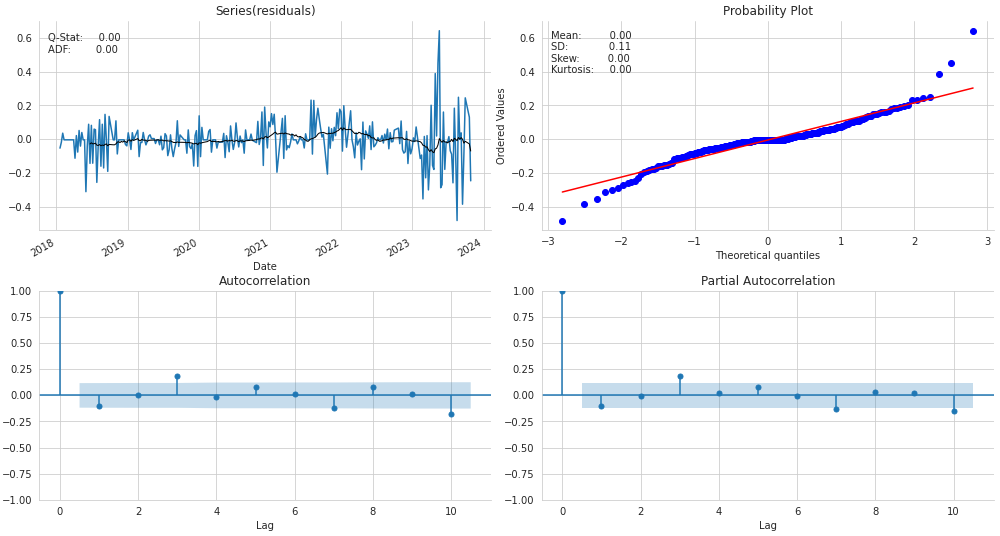

In [10]:
plot_correlogram(fitted)

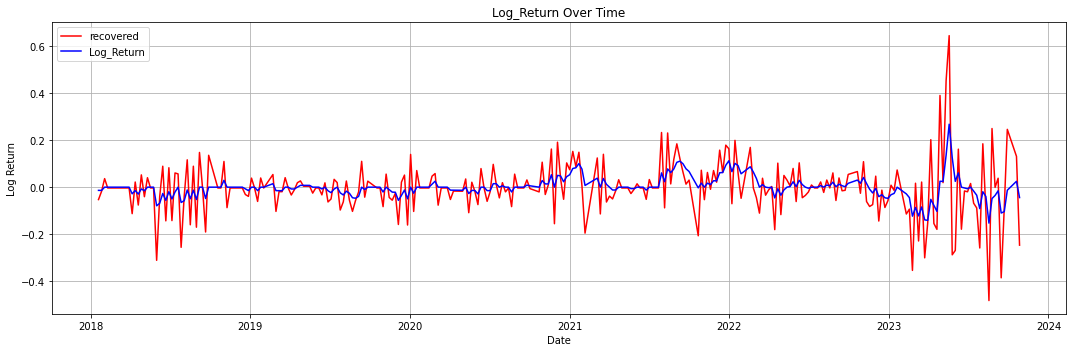

In [11]:
# plot fitted and original one: 

# Separate plot for 'Log_Return' for clarity and because it might be on a different scale
plt.figure(figsize=(15, 5))
plt.plot(ro.index, fitted, label="recovered", color="red")
plt.plot(ro.index, ro, label="Log_Return", color="blue")
plt.title("Log_Return Over Time")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

## Regression on Google Trend

In [12]:
import pandas as pd
gdelt_news = pd.read_csv('../data/gdelt_week_friday.csv')

In [16]:
gdelt_news

,week_friday,count,mean,max,min,std
0,2018-01-05,56,0.724490,3.539823,-1.198157,1.214640
1,2018-01-12,153,0.540838,5.479452,-3.154574,1.259208
2,2018-01-19,145,0.535426,4.000000,-6.727829,1.498560
3,2018-01-26,154,0.939129,9.049774,-4.878049,1.648920
4,2018-02-02,143,0.778991,4.735376,-2.923977,1.378502
...,...,...,...,...,...,...
301,2023-10-13,287,0.851689,5.919003,-4.309064,1.759527
302,2023-10-20,264,0.637306,5.354331,-3.771290,1.771544
303,2023-10-27,288,0.733813,6.226054,-4.597701,1.426142
304,2023-11-03,334,0.962412,5.957447,-6.626506,2.187093


In [17]:
gdelt_news.week_friday = pd.to_datetime(gdelt_news.week_friday)

df_ro = pd.DataFrame(ro)
df_ro.columns = ['Log_Return']
df_reg_on_gdelt = gdelt_news.merge(df_ro, left_on = 'week_friday', right_on = 'Date', how = 'right')

In [18]:
df_reg_on_gdelt = df_reg_on_gdelt.dropna()

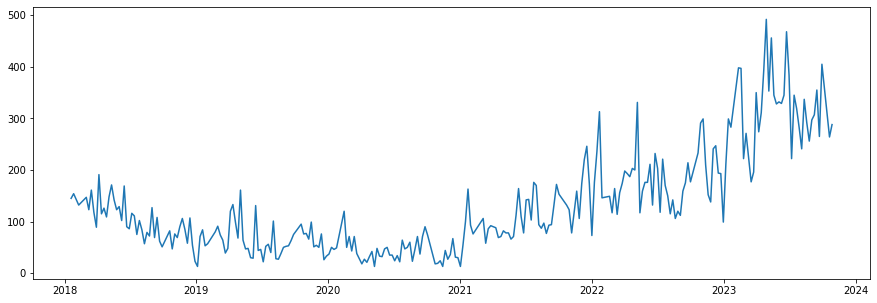

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(df_reg_on_gdelt['week_friday'], df_reg_on_gdelt['count'])

In [20]:
import numpy as np
df_reg_on_gdelt['count_diff'] = df_reg_on_gdelt['count'].diff()
df_reg_on_gdelt['count_log'] = np.log(df_reg_on_gdelt['count'])
df_reg_on_gdelt['max_diff'] = df_reg_on_gdelt['max'].diff()
df_reg_on_gdelt['min_diff'] = df_reg_on_gdelt['min'].diff()
df_reg_on_gdelt['std_diff'] = df_reg_on_gdelt['std'].diff()
df_reg_on_gdelt['max_min_diff'] = df_reg_on_gdelt['max'] - df_reg_on_gdelt['min'] 
df_reg_on_gdelt = df_reg_on_gdelt.dropna().reset_index(drop = True)

In [21]:
df_reg_on_gdelt.columns

Index(['week_friday', 'count', 'mean', 'max', 'min', 'std', 'Log_Return',
       'count_diff', 'count_log', 'max_diff', 'min_diff', 'std_diff',
       'max_min_diff'],
      dtype='object')

In [30]:
X_train_scaled

,count,mean,min,max,std
0,0.470000,0.881547,0.586842,0.756546,0.374108
1,0.433333,0.847245,0.767922,0.308180,0.263188
2,0.396667,0.861920,0.744337,0.398035,0.387901
3,0.446667,0.741274,0.684736,0.295711,0.335430
4,0.366667,0.869044,0.819980,0.398035,0.320310
...,...,...,...,...,...
195,0.503333,0.860701,0.720627,0.394814,0.456823
196,0.336667,0.901661,0.807211,0.205082,0.300835
197,0.476667,0.842356,0.493774,0.202157,0.281595
198,0.536667,0.833580,0.777435,0.333787,0.232513


## Simple Linear Regression 

In [41]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

X_train = df_reg_on_gdelt[['count', 'mean', 'min', 'max', 'std']].iloc[0:200, :]
y_train = df_reg_on_gdelt['Log_Return'][0:200]

X_test = df_reg_on_gdelt[['count', 'mean', 'min', 'max', 'std']].iloc[200:, :]
y_test = df_reg_on_gdelt['Log_Return'][200:]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

import statsmodels.api as sm

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)

#X_train_scaled_sm = sm.add_constant(X_train_scaled)

# Create a model
model_sm = sm.OLS(y_train, X_train_scaled)

# Fit the model
results = model_sm.fit()

# Get the summary of the regression
summary = results.summary()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:             Log_Return   R-squared (uncentered):                   0.185
Model:                            OLS   Adj. R-squared (uncentered):              0.164
Method:                 Least Squares   F-statistic:                              8.827
Date:                Fri, 10 Nov 2023   Prob (F-statistic):                    1.44e-07
Time:                        01:28:54   Log-Likelihood:                          408.40
No. Observations:                 200   AIC:                                     -806.8
Df Residuals:                     195   BIC:                                     -790.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [33]:
# Add a constant to the scaled test data
#X_test_scaled_sm = sm.add_constant(X_test_scaled)

# Use the trained model to make predictions on the scaled test data
y_test_pred = results.predict(X_test_scaled)

# Calculate the actual direction of change
actual_changes = np.sign(np.diff(y_test))

# Calculate the predicted direction of change
predicted_changes = np.sign(np.diff(y_test_pred))

# Calculate the hit rate
hits = np.sum(actual_changes == predicted_changes)
total_predictions = len(actual_changes)

# Hit rate
hit_rate = hits / total_predictions

hit_rate

0.4533333333333333

## Adding Polynomial Terms

In [34]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interaction_scaled = poly.fit_transform(X_train_scaled)
# Get the names of the features created
interaction_feature_names = poly.get_feature_names(X_train.columns)

X_train_interaction_scaled = pd.DataFrame(X_train_interaction_scaled, columns = interaction_feature_names)

X_train_interaction_scaled_sm = sm.add_constant(X_train_interaction_scaled)

model_interaction_sm = sm.OLS(y_train, X_train_interaction_scaled_sm)

results_interaction = model_interaction_sm.fit()

summary_interaction = results_interaction.summary()
print(summary_interaction)


                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     3.943
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           3.80e-06
Time:                        01:26:17   Log-Likelihood:                 417.97
No. Observations:                 200   AIC:                            -803.9
Df Residuals:                     184   BIC:                            -751.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.003      1.627      0.1

In [35]:
# First, we will transform the test data using the same PolynomialFeatures and scaler as the training data
X_test_interaction = poly.transform(X_test)
X_test_interaction_scaled = scaler_interaction.transform(X_test_interaction)
X_test_interaction_scaled_df = pd.DataFrame(X_test_interaction_scaled, columns=interaction_feature_names)

# Add a constant to the scaled test data
X_test_interaction_scaled_sm = sm.add_constant(X_test_interaction_scaled_df)

# Use the trained model to make predictions on the scaled test data
y_test_pred = results_interaction.predict(X_test_interaction_scaled_sm)

# Assume y_test contains the actual returns and y_test_pred contains the predicted returns
# Calculate the actual direction of change
actual_direction = np.sign(y_test - y_test.shift(1))

# Calculate the predicted direction of change
predicted_direction = np.sign(y_test_pred - y_test.shift(1))

# Remove the first element since it will be NaN after the shift
actual_direction = actual_direction[1:]
predicted_direction = predicted_direction[1:]

# Calculate the number of correct predictions
print('act', actual_direction)
print('pre', predicted_direction)
correct_predictions = np.sum(actual_direction == predicted_direction)

# Calculate the hit rate
hit_rate = correct_predictions / len(actual_direction)

hit_rate



act 201   -1.0
202    1.0
203   -1.0
204    1.0
205    1.0
      ... 
271   -1.0
272    1.0
273    1.0
274    1.0
275   -1.0
Name: Log_Return, Length: 75, dtype: float64
pre 1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
       ..
271   NaN
272   NaN
273   NaN
274   NaN
275   NaN
Length: 151, dtype: float64


ValueError: Can only compare identically-labeled Series objects

In [36]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_interaction_scaled = poly.fit_transform(X_train_scaled)
# Get the names of the features created
interaction_feature_names = poly.get_feature_names(X_train.columns)

X_train_interaction_scaled = pd.DataFrame(X_train_interaction_scaled, columns = interaction_feature_names)

X_train_interaction_scaled_sm = sm.add_constant(X_train_interaction_scaled)

model_interaction_sm = sm.OLS(y_train, X_train_interaction_scaled_sm)

results_interaction = model_interaction_sm.fit()

summary_interaction = results_interaction.summary()
print(summary_interaction)


                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     3.091
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           3.24e-05
Time:                        01:26:55   Log-Likelihood:                 419.77
No. Observations:                 200   AIC:                            -797.5
Df Residuals:                     179   BIC:                            -728.3
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.004      1.123      0.2

In [80]:
y_pred

0     0.130889
1     0.127845
2     0.033952
3     0.018186
4     0.125164
        ...   
70   -0.025479
71    0.029946
72    0.004725
73   -0.002587
74    0.043625
Length: 75, dtype: float64

In [79]:
y_test.shift(1)

200         NaN
201   -0.045561
202   -0.006682
203   -0.034094
204   -0.011628
         ...   
270   -0.015464
271   -0.109699
272   -0.103752
273   -0.012945
274    0.024923
Name: Log_Return, Length: 75, dtype: float64

In [74]:
# To evaluate the model, we'll first need to transform the test data in the same way we did the training data
# Create the squared terms and interaction terms for the test set
X_test_poly = poly.transform(X_test_scaled)

# Convert to a DataFrame with the appropriate feature names
X_test_poly_df = pd.DataFrame(X_test_poly)

# Add a constant to the DataFrame for the intercept
X_test_poly_with_constant = sm.add_constant(X_test_poly_df)

# Use the fitted model to make predictions on the test set
y_pred = results_interaction.predict(X_test_poly_with_constant)
print(y_pred)
# Assume y_test contains the actual returns and y_test_pred contains the predicted returns
# Calculate the actual direction of change
actual_direction = np.sign(y_test - y_test.shift(1))

# Calculate the predicted direction of change
predicted_direction = np.sign(y_pred - y_test.shift(1))
print(predicted_direction)

# Remove the first element since it will be NaN after the shift
actual_direction = actual_direction[1:]
predicted_direction = predicted_direction[1:]

# Calculate the number of correct predictions
correct_predictions = np.sum(actual_direction == predicted_direction)

# Calculate the hit rate
hit_rate = correct_predictions / len(actual_direction)

hit_rate


0     0.130889
1     0.127845
2     0.033952
3     0.018186
4     0.125164
        ...   
70   -0.025479
71    0.029946
72    0.004725
73   -0.002587
74    0.043625
Length: 75, dtype: float64
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
270   NaN
271   NaN
272   NaN
273   NaN
274   NaN
Length: 150, dtype: float64


ValueError: Can only compare identically-labeled Series objects